## **Στοιχεία Μέλους 1: Στρατάκης Μιχαήλ Α.Μ: 03117503**

## **Στοιχεία Μέλους 2: -**

# **Τεχνητή Νοημοσύνη: Εργαστηριακή Άσκηση 2**
---

## Ο στόχος της εργασίας είναι η κατασκευή ενός συστήματος προτάσεων (Recommendation System) για ταινίες. Οι προτάσεις αυτές θα πηγάζουν τόσο από τα χαρακτηριστικά της ταινίας όσο και από ορισμένες αξιολογήσεις του κάθε χρήστη.

## Στα δεδομένα της άσκησης περιλαμβάνονται ένα αρχείο με το όνομα movies_metadata.csv το όποιο περιέχει τα χαρακτηριστικά κάθε ταινίας όπως θέμα, σκηνοθέτης ηθοποιοί, λέξεις κλειδιά κ.α. από το imdb καθώς και τα αρχεία ratings.csv τα όποια περιέχουν πραγματικές αξιολογήσεις χρηστών, χωρισμένες σε train και σε test.


## Πριν αρχίσουμε την οποιαδήποτε εκτέλεση θα εισάγουμε τα δεδομένα από το Kaggle.

In [ ]:
!pip install kaggle

In [ ]:
!mkdir .kaggle

mkdir: cannot create directory ‘.kaggle’: File exists


In [ ]:
import json

token = {"username":"el17503","key":"hidden"} 
with open('/content/.kaggle/kaggle.json', 'w') as file: 
  json.dump(token, file)

In [ ]:
!cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json
!kaggle config set -n path -v{/content}

- path is now set to: {/content}


In [ ]:
!chmod 600 /root/.kaggle/kaggle.json

## Eισαγωγή του movies_metadata.csv

In [ ]:
!kaggle datasets download -d georgefila/movies-metadata -p /content

movies-metadata.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!unzip \*.zip

Archive:  movies-metadata.zip
replace movies_metadata.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: movies_metadata.csv     


In [ ]:
%%capture 
#install swi-prolog
!sudo apt-get install software-properties-common
!sudo apt-add-repository ppa:swi-prolog
!sudo apt-get update
!sudo apt-get install swi-prolog
#install pyswip
!pip install pyswip


# **Μέρος 1: Μελέτη των Metadata, Δημιουργία κόσμου και των βασικών queries.**


In [ ]:
import pandas as pd
from pyswip import Prolog

In [ ]:
# Η βιβλιοθήκη pandas είναι χρήσιμη για την εργασία με τέτοια δεδομένα
import pandas as pd 
# Διάβασμα του αρχείου 'movie_metadata.csv' 
data = pd.read_csv("movies_metadata.csv") 
#Στο csv υπαρχούν κελία με nan τιμές
#Στις θέσεις αυτές βάζουμε 'UNK' πράγμα που  κάνουμε με την παρακάτω συνάρτηση
data.fillna("UNK", inplace=True)
# Preview the first 5 lines of the loaded data 
data.head()

,Unnamed: 0,budget,genres,homepage,id,plot_keywords,language,original_title,overview,popularity,production_companies,production_countries,release_date,gross,duration,spoken_languages,status,tagline,movie_title,vote_average,num_voted_users,title_year,country,director_name,actor_1_name,actor_2_name,actor_3_name
0,0,237000000,Action|Adventure|Fantasy|Science Fiction,http://www.avatarmovie.com/,19995,culture clash|future|space war|space colony|so...,English,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{'name': 'Ingenious Film Partners', 'id': 289...","[{'iso_3166_1': 'US', 'name': 'United States o...",2009-12-10,2787965087,162,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,2009,United States of America,James Cameron,Zoe Saldana,Sigourney Weaver,Stephen Lang
1,1,300000000,Adventure|Fantasy|Action,http://disney.go.com/disneypictures/pirates/,285,ocean|drug abuse|exotic island|east india trad...,English,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{'name': 'Walt Disney Pictures', 'id': 2}, {'...","[{'iso_3166_1': 'US', 'name': 'United States o...",2007-05-19,961000000,169,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,2007,United States of America,Gore Verbinski,Orlando Bloom,Keira Knightley,Stellan Skarsgård
2,2,245000000,Action|Adventure|Crime,http://www.sonypictures.com/movies/spectre/,206647,spy|based on novel|secret agent|sequel|mi6|bri...,Français,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{'name': 'Columbia Pictures', 'id': 5}, {'nam...","[{'iso_3166_1': 'GB', 'name': 'United Kingdom'...",2015-10-26,880674609,148,"[{'iso_639_1': 'fr', 'name': 'Français'}, {'is...",Released,A Plan No One Escapes,Spectre,6.3,4466,2015,United Kingdom,Sam Mendes,Christoph Waltz,Léa Seydoux,Ralph Fiennes
3,3,250000000,Action|Crime|Drama|Thriller,http://www.thedarkknightrises.com/,49026,dc comics|crime fighter|terrorist|secret ident...,English,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{'name': 'Legendary Pictures', 'id': 923}, {'...","[{'iso_3166_1': 'US', 'name': 'United States o...",2012-07-16,1084939099,165,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106,2012,United States of America,Christopher Nolan,Michael Caine,Gary Oldman,Anne Hathaway
4,4,260000000,Action|Adventure|Science Fiction,http://movies.disney.com/john-carter,49529,based on novel|mars|medallion|space travel|pri...,English,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{'name': 'Walt Disney Pictures', 'id': 2}]","[{'iso_3166_1': 'US', 'name': 'United States o...",2012-03-07,284139100,132,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124,2012,United States of America,Andrew Stanton,Lynn Collins,Samantha Morton,Willem Dafoe


In [ ]:
def clean_text(text):
  text = text.replace(u'\xa0', u'')
  text = text.replace(u"'", u'')
  return text

In [ ]:
#create World
#Ορίζουμε τον κόσμο μας
prolog = Prolog()

#Για κάθε row του πίνακα φτιάχνουμε τα κατηγορήματα που θέλουμε να αποθηκέυσουμε
#αρχικά σε μια λίστα με το όνομα literals
literals = []

actors_counter = 0
genre_counter = 0
director_counter = 0 
title_year_counter = 0
users_voted_counter = 0 
vote_average_counter = 0
duration_counter = 0
production_country_counter = 0
production_companies_counter = 0
popularity_counter = 0
language_counter = 0
color_counter = 0
plot_keyword_counter = 0

for row in data.itertuples(index=True, name='Pandas'):
  plot_keywords = clean_text(getattr(row, 'plot_keywords'))
  language = clean_text(getattr(row, 'language'))
  popularity = clean_text(str(getattr(row, 'popularity')))
  production_companies = clean_text(str(getattr(row, 'production_companies')))
  production_countries = clean_text(str(getattr(row, 'production_countries')))
  duration = clean_text(str(getattr(row, 'duration')))
  movie_title = clean_text(getattr(row, 'movie_title'))
  vote_average = clean_text(str(getattr(row, 'vote_average')))
  num_voted_users = clean_text(str(getattr(row, 'num_voted_users')))
  title_year = getattr(row, 'title_year')
  director = clean_text(str(getattr(row, 'director_name')))

  if movie_title != "UNK":

    # plot_keyword(Movie, Plot_Keyword).
    for plot_keyword in plot_keywords.split("|"):
      literals.append("plot_keyword('"+ movie_title +"','"+ plot_keyword +"')")
      plot_keyword_counter += 1
      if plot_keyword == "black and white":
        # we have a total of 6 black and white movies, after doing some checks
        # color(Movie, Color).
        literals.append("color('"+ movie_title +"','" + "black_and_white" + "')")
        color_counter += 1
      else:
        # color(Movie, Color).
        literals.append("color('"+ movie_title +"','" + "colored" +"')")
        color_counter += 1

    # language(Movie, Language).
    if language != "UNK":
      literals.append("language('"+ movie_title +"','"+ language +"')")
      language_counter += 1

    # popularity(Movie, popularity).  
    if popularity != "UNK":
      # popularity(Movie, very_popular).
      if float(popularity) > 130:
        literals.append("popularity('"+ movie_title +"','high_popular')")
        popularity_counter += 1      
      # popularity(Movie, medium_popular).     
      elif float(popularity) < 130 and float(popularity) >= 100:
        literals.append("popularity('"+ movie_title +"','very_popular')")
        popularity_counter += 1 
      # popularity(Movie, medium_popular).
      elif float(popularity) < 100 and float(popularity) >= 50:
        literals.append("popularity('"+ movie_title +"','medium_popular')")
        popularity_counter += 1
      # popularity(Movie, low_popular).
      elif float(popularity) < 50 and float(popularity) >= 10:
        literals.append("popularity('"+ movie_title +"','low_popular')")
        popularity_counter += 1 
      # popularity(Movie, very_low_popular).
      else:
        literals.append("popularity('"+ movie_title +"','very_low_popular')")
        popularity_counter += 1
    
    # production_companies(Movie, production_companies).
    if production_companies != "UNK":
      for i in range(len(production_companies)):
        if production_companies[i] == 'n' and production_companies[i + 1] == 'a' and production_companies[i + 2] == 'm' and production_companies[i + 3] == 'e':
          studio_company = ""
          for j in range(i + 6, i + 50):
            if production_companies[j] == ',':
              break
            studio_company = studio_company + production_companies[j]
          literals.append("production_companies('"+ movie_title +"','" + studio_company +"')")
          production_companies_counter += 1

    # production_country(Movie, production_country).
    if production_countries != "UNK":
      for i in range(len(production_countries)):
        if production_countries[i] == 'n' and production_countries[i + 1] == 'a' and production_countries[i + 2] == 'm' and production_countries[i + 3] == 'e':
          country = ""
          for j in range(i + 6, i + 50):
            if production_countries[j] == '}':
              break
            country = country + production_countries[j]
          literals.append("production_country('"+ movie_title +"','" + country +"')")
          production_country_counter += 1

    # duration
    if duration != "UNK":
      # duration(Movie, long).
      if float(duration) > 120:
        literals.append("duration('"+ movie_title +"','long')")
        duration_counter += 1
      # duration(Movie, medium).
      elif float(duration) < 120 and float(duration) >= 60:
        literals.append("duration('"+ movie_title +"','medium')")
        duration_counter += 1
      # duration(Movie, short).
      else:
        literals.append("duration('"+ movie_title +"','short')")
        duration_counter += 1

    # vote_average
    if vote_average != "UNK":
      # vote_average(Movie, aver_over_9).
      if float(vote_average) > 9.0:
        literals.append("vote_average('"+ movie_title +"','aver_over_9')")
        vote_average_counter += 1
      # vote_average(Movie, aver_over_8.0).
      elif float(vote_average) < 9.0 and float(vote_average) >= 8.0:
        literals.append("vote_average('"+ movie_title +"','aver_over_8.0')")    
        vote_average_counter += 1
      # vote_average(Movie, aver_over_7.5).
      elif float(vote_average) < 8.0 and float(vote_average) >= 7.5:
        literals.append("vote_average('"+ movie_title +"','aver_over_7.5')")    
        vote_average_counter += 1  
      # vote_average(Movie, aver_over_7).
      elif float(vote_average) < 7.5 and float(vote_average) >= 7.0:
        literals.append("vote_average('"+ movie_title +"','aver_over_7')")    
        vote_average_counter += 1
      # vote_average(Movie, aver_over_6).
      elif float(vote_average) < 7.0 and float(vote_average) >= 6.0:
        literals.append("vote_average('"+ movie_title +"','aver_over_6')")    
        vote_average_counter += 1
      # vote_average(Movie, aver_over_3).
      elif float(vote_average) < 6.0 and float(vote_average) >= 4.0:
        literals.append("vote_average('"+ movie_title +"','aver_over_4')")    
        vote_average_counter += 1
      # vote_average(Movie, aver_under_4).
      else:
        literals.append("vote_average('"+ movie_title +"','aver_under_4')")
        vote_average_counter += 1

    # num_voted_users, currently not used in the Rules and the recommender
    if num_voted_users != "UNK":
      # num_voted_users(Movie, high).  
      if int(num_voted_users) > 8000:
        literals.append("users_voted('"+ movie_title +"','high')")
        users_voted_counter += 1      
      # num_voted_users(Movie, moderate).     
      elif int(num_voted_users) < 8000 and int(num_voted_users) >= 4000:
        literals.append("users_voted('"+ movie_title +"','moderate')")
        users_voted_counter += 1
      # num_voted_users(Movie, low).  
      else:
        literals.append("users_voted('"+ movie_title +"','low')")    
        users_voted_counter += 1
    
    # title_year(Movie, title_year).
    if title_year != "UNK":
      # example: convert 2009.0 to 2009 and then to '2009'
      literals.append("title_year('"+ movie_title +"','" + str(int(title_year)) + "')") 
      title_year_counter += 1

    # director(Movie, director).
    if director != "UNK":
      literals.append("director('"+ movie_title +"','" + director + "')")
      director_counter += 1

    # genre(Movie, Genre).
    for genre in getattr(row, 'genres').split("|"):
      literals.append("genre('"+ movie_title +"','"+ genre +"')")
      genre_counter += 1

    # actors(Movie, Actor_(1-2-3)__name).
    for actor in [getattr(row, 'actor_1_name'), getattr(row, 'actor_2_name'), getattr(row, 'actor_3_name')]:
      literals.append("actors('"+ movie_title +"','"+ actor.replace("'",'"') +"')") 
      actors_counter += 1 
  
#Η Prolog θέλει τα κατηγορήματά της με την σειρά 
literals.sort()
print(f'Our knowlegde base contains {len(literals)} Predicates')
for literal in literals:
    prolog.assertz(literal)

#Επίσης μπορούμε να κάνουμε consult ένα έτοιμο αρχείο στον κόσμο όπως παρακάτω
#prolog.consult(path + "db.pl")

Our knowlegde base contains 153412 Predicates


### Παρακάτω έχουμε μια απεικόνιση των δεδομένων της γνώσης μας σε αριθμό τα οποία απεικονίζονται σε bar-plot. Για παράδειγμα έχουμε 14409 κατηγορήματα actors(Movie, Actor_name)

In [ ]:
knowlegde_base_info = {}
knowlegde_base_info["actors(Movie, Actor_name)"] = actors_counter
knowlegde_base_info["genre(Movie, Genre)"] = genre_counter
knowlegde_base_info["director(Movie, Director)"] = director_counter
knowlegde_base_info["title_year(Movie, Title_year)"] = title_year_counter
knowlegde_base_info["users_voted(Movie, User_Votes)"] = users_voted_counter
knowlegde_base_info["vote_average(Movie, Votes_Average)"] = vote_average_counter
knowlegde_base_info["duration(Movie, Duration)"] = duration_counter
knowlegde_base_info["production_country(Movie, Production_country)"] = production_country_counter
knowlegde_base_info["production_companies(Movie, Production_companies)"] = production_companies_counter
knowlegde_base_info["popularity(Movie, Popularity)"] = popularity_counter
knowlegde_base_info["language(Movie, Language)"] = language_counter
knowlegde_base_info["color(Movie, Color)"] = color_counter
knowlegde_base_info["plot_keyword(Movie, Plot_keyword)"] = plot_keyword_counter

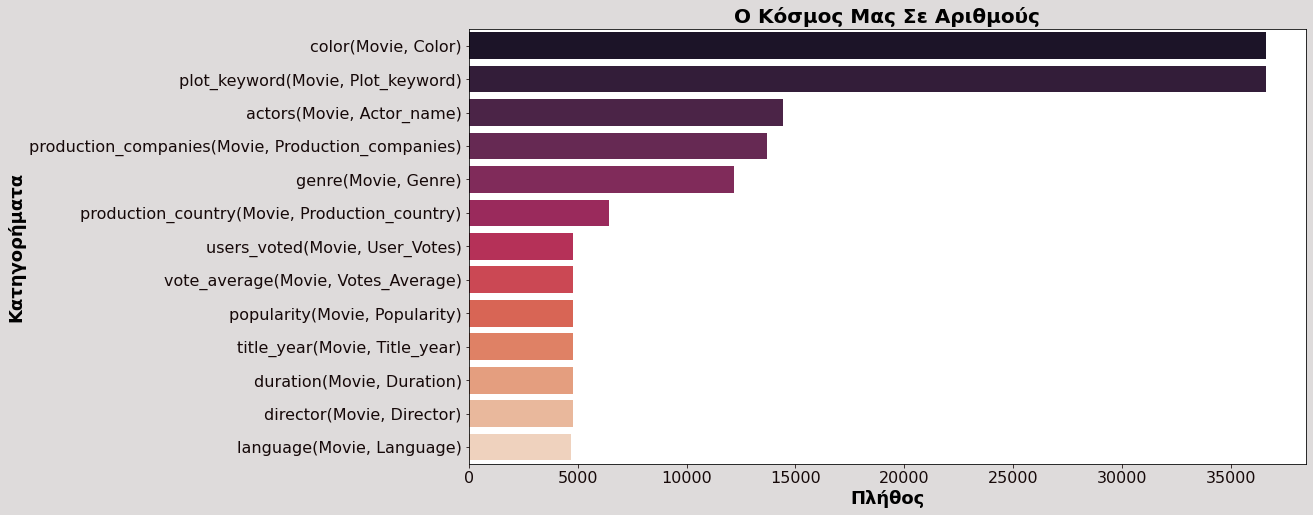

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sorted_knowlegde_base_info = dict(sorted(knowlegde_base_info.items(), key=lambda item: item[1],reverse=True))
x_axis = list(sorted_knowlegde_base_info.keys())
y_axis = list(sorted_knowlegde_base_info.values())
plt.figure(figsize=(15,8),  facecolor='#dedbdb')
plt.xlabel("Πλήθος", fontweight='bold', fontsize="18")
plt.ylabel("Κατηγορήματα", fontweight='bold', fontsize="18")
plt.title("Ο Κόσμος Μας Σε Αριθμούς", fontweight='bold',fontsize="20")
plt.tick_params(colors='#160909', axis='both', labelsize=16)
sns.barplot(x = y_axis, y = x_axis, palette = 'rocket')
plt.show()

## Έχουμε ορίσει τον κόσμο μας σε ένα ικανοποιητικό σημείο, έχοντας συμπεριλάβει τα παραπάνω κατηγορήματα.

## Πλέον είμαστε έτοιμοι να προχωρήσουμε στον ορισμό κανόνων.

## Κανόνας 1: Όλες τις ταινίες με Κοινό θέμα (κάποιες λέξεις σχετικά με το genre κοινές) 

## Όμως ας δούμε ποιός είναι ο μέγιστος αριθμός χαρακτηριστικών(genres) στο dataset μας, ώστε να γνωρίζουμε από ποιο αριθμό μπορούμε να ξεκινήσουμε τον Κανόνα 1.

## Ας δούμε και πόσες ταινίες έχουν το μέγιστο αριθμό από genre.

In [ ]:
data['genres']
max = 0
index = 0
for i in range(len(data['genres'])):
  current = 0
  for j in data['genres'][i].split("|"):
    current += 1
  if current > max:
    max = current
    index = i
print("Μax Genre Definition has the following: " + str(data['genres'][index]))
movies_with_7_genres = 0
movies_with_6_genres = 0
movies_with_5_genres = 0
index_5 = []
movies_with_4_genres = 0
for i in range(len(data['genres'])):
  current = 0
  for j in data['genres'][i].split("|"):
    current += 1
  if current == max:
    movies_with_7_genres +=1
  if current == max - 1:
    movies_with_6_genres +=1
  if current == max - 2:
    movies_with_5_genres +=1
    index_5.append(i)
  if current == max - 3:
    movies_with_4_genres +=1
print(f'Maximum Genres are {max} and belong to movie: ' + str(data['movie_title'][index]))
print(f'Totally there are another {movies_with_7_genres} movies with {max} genres')
print(f'Totally there are another {movies_with_6_genres} movies with {max - 1} genres')
print(f'Totally there are another {movies_with_5_genres} movies with {max - 2} genres')
print(f'Totally there are another {movies_with_4_genres} movies with {max - 3} genres')

Μax Genre Definition has the following: Action|Adventure|Animation|Comedy|Family|Fantasy|Science Fiction
Maximum Genres are 7 and belong to movie: Jimmy Neutron: Boy Genius
Totally there are another 4 movies with 7 genres
Totally there are another 33 movies with 6 genres
Totally there are another 187 movies with 5 genres
Totally there are another 636 movies with 4 genres


## Βρήκαμε πως έχουμε μόλις 4 ταινίες με 7 χαρακτηριστικά στο dataset μας. Οπότε σίγουρα δε θα επιλέξουμε τον αριθμό 7 στον πρώτο κανόνα. Θεωρητικά θα μπορούσαμε αν θέλαμε να δημιουργήσουμε κάτι πολύ ακριβές. 

## Το ίδιο ισχύει και με τον αριθμό 6 όπου έχουμε 33 ταινίες με 6 χαρακτηριστικά και τον αριθμό 5 όπου έχουμε 187 ταινίες με 5 χαρακτηριστικά.

## Ωστόσο έχουμε 636 ταινίες με 4 χαρακτηριστικά. Ο αριθμός 4 είναι αυτός με τον οποίο θα ξεκινήσουμε τον πρώτο κανόνα. Να τονίσουμε πως εμείς απλά βρήκαμε πόσες ταινίες έχουν 4 χαρακτηριστικά. Παρατηρήσαμε πως υπάρχουν αρκετές ταινίες με 4 χαρακτηριστικά, ωστόσο αυτός ο αριθμός διαφέρει από το πόσες ταινίες έχουν τουλάχιστον 4 χαρακτηριστικά κοινά. Αυτό άλλωστε είναι και ο σκοπός του Κανόνα 1. Τέλος, δοκιμάσαμε να διαλέγαμε τον αριθμό 5 ωστόσο τότε όχι μόνο το χρονικό κόστος αυξήθηκε αλλά βρήκαμε σχεδόν μηδενικό ποσοστό ταινιών με 5 κοινά χαρακτηριστικά.

## Κανόνας 1: Όλες τις ταινίες με Κοινό θέμα (4 λέξεις σχετικά με το genre κοινές) 

In [ ]:
rules_dict = {}

prolog.assertz('''(find_sim_genre_4(X, Y) :-  
                              genre(X, A), 
                              genre(Y, A), 
                              genre(X, B), 
                              genre(Y, B), 
                              A \= B,
                              genre(X, C), 
                              genre(Y, C),
                              A \= C,
                              B \= C,  
                              genre(X, D), 
                              genre(Y, D),
                              A \= D,
                              B \= D, 
                              C \= D,
                              X \= Y)''')

rules_dict["Rule: find_sim_genre_4(X, Y)"] = "find_sim_genre_4('"

## Aς τρέξουμε τον παραπάνω κανόνα για να βεβαιωθούμε ως προς τη λειτουργικότητα.

In [ ]:
def Movie_Test_sim_4(movie):
  s = set()
  q = prolog.query("find_sim_genre_4('" + movie +"',M)")
  for soln in q:
    m = soln['M'] 
    if m not in s:
      s.add(m)
  q.close()
  answers = s
  return answers

In [ ]:
movie_match = {}
for i in range(5):
  movie_title = clean_text(data['movie_title'][i])
  movie_match[movie_title] = Movie_Test_sim_4(movie_title)
for k,v in movie_match.items():
  print(f'Movie with name: {k} has --> {len(v)} <-- similar movies that have 4 common genres')

Movie with name: Avatar has --> 28 <-- similar movies that have 4 common genres
Movie with name: Pirates of the Caribbean: At Worlds End has --> 0 <-- similar movies that have 4 common genres
Movie with name: Spectre has --> 0 <-- similar movies that have 4 common genres
Movie with name: The Dark Knight Rises has --> 71 <-- similar movies that have 4 common genres
Movie with name: John Carter has --> 0 <-- similar movies that have 4 common genres


## Κανόνας 2: Όλες τις ταινίες με αρκετά κοινό θέμα (3 κοινά χαρακτηριστικά)

## Προφανώς μέσα σε αυτές τις ταινίες, κάποιες μπορεί να έχουν περισσότερα κοινά χαρακτηριστικά. Ωστόσο εμείς κρατάμε 2 κοινά μιας και ο κανόνας είναι πιο "χαλαρός" από τον Κανόνα 1 και πιο γρήγορος επίσης.

In [ ]:
prolog.assertz('''(find_sim_genre_3(X, Y) :-  
                              genre(X, A), 
                              genre(Y, A), 
                              genre(X, B), 
                              genre(Y, B), 
                              A \= B,
                              genre(X, C),
                              genre(Y, C),
                              A \= C,
                              B \= C,
                              X \= Y)''')

rules_dict["Rule: find_sim_genre_3(X, Y)"] = "find_sim_genre_3('"

## Κανόνας 3: Όλες τις ταινίες με σχετικά κοινό θέμα (1, 2 κοινά χαρακτηριστικό)

In [ ]:
prolog.assertz('''(find_sim_genre_2(X, Y) :-  
                              genre(X, A), 
                              genre(Y, A),
                              genre(X, B), 
                              genre(Y, B), 
                              A \= B,
                              X \= Y)''')

rules_dict["Rule: find_sim_genre_2(X, Y)"] = "find_sim_genre_2('"

prolog.assertz('''(find_sim_genre_1(X, Y) :-  
                              genre(X, A), 
                              genre(Y, A),
                              X \= Y)''')

rules_dict["Rule: find_sim_genre_1(X, Y)"] = "find_sim_genre_1('"

## Κανόνας 4: Όλες τις ταινίες με κοινό σκηνοθέτη.

In [ ]:
prolog.assertz('''(find_same_director(X, Y) :-  
                              director(X, A), 
                              director(Y, A), 
                              X \= Y)''')

rules_dict["Rule: find_same_director(X, Y)"] = "find_same_director('"

## Κανόνας 5: Όλες τις ταινίες με κοινή πλοκή (4 λέξεις κλειδιά της πλοκής κοινές)

In [ ]:
prolog.assertz('''(find_same_plot_keyword_4(X, Y) :-  
                              plot_keyword(X, A), 
                              plot_keyword(Y, A),
                              plot_keyword(X, B), 
                              plot_keyword(Y, B),
                              A \= B,
                              plot_keyword(X, C), 
                              plot_keyword(Y, C),
                              A \= C,
                              B \= C,
                              plot_keyword(X, D), 
                              plot_keyword(Y, D),
                              A \= D,
                              B \= D,
                              C \= D,
                              X \= Y)''') 

rules_dict["Rule: find_same_plot_keyword_4(X, Y)"] = "find_same_plot_keyword_4('"

## Κανόνας 6: Όλες τις ταινίες με σχετικά ίδια πλοκή (2, 3 λέξεις κλειδιά κοινές)

In [ ]:
prolog.assertz('''(find_same_plot_keyword_3(X, Y) :-  
                              plot_keyword(X, A), 
                              plot_keyword(Y, A),
                              plot_keyword(X, B), 
                              plot_keyword(Y, B),
                              A \= B,
                              plot_keyword(X, C), 
                              plot_keyword(Y, C),
                              A \= C,
                              B \= C,
                              X \= Y)''') 

rules_dict["Rule: find_same_plot_keyword_3(X, Y)"] = "find_same_plot_keyword_3('"

prolog.assertz('''(find_same_plot_keyword_2(X, Y) :-  
                              plot_keyword(X, A), 
                              plot_keyword(Y, A),
                              plot_keyword(X, B), 
                              plot_keyword(Y, B),
                              A \= B,
                              X \= Y)''') 

rules_dict["Rule: find_same_plot_keyword_2(X, Y)"] = "find_same_plot_keyword_2('"

prolog.assertz('''(find_same_plot_keyword_1(X, Y) :-  
                              plot_keyword(X, A), 
                              plot_keyword(Y, A),
                              X \= Y)''') 

rules_dict["Rule: find_same_plot_keyword_1(X, Y)"] = "find_same_plot_keyword_1('"

## Κανόνας 7: Όλες τις ταινίες με ίδιους τους βασικούς ηθοποιούς (και τους 3)

In [ ]:
prolog.assertz('''(find_same_actors_3(X, Y) :-  
                              actors(X, A), 
                              actors(Y, A),
                              actors(X, B), 
                              actors(Y, B),
                              A \= B,
                              actors(X, C), 
                              actors(Y, C),
                              A \= C,
                              B \= C,
                              X \= Y)''')

rules_dict["Rule: find_same_actors_3(X, Y)"] = "find_same_actors_3('"

## Κανόνας 8: Όλες τις ταινίες με αρκετά ίδιους βασικούς ηθοποιούς (2 βασικούς ηθοποιούς κοινούς).

In [ ]:
prolog.assertz('''(find_same_actors_2(X, Y) :-  
                              actors(X, A), 
                              actors(Y, A),
                              actors(X, B), 
                              actors(Y, B),
                              A \= B,
                              X \= Y)''')

rules_dict["Rule: find_same_actors_2(X, Y)"] = "find_same_actors_2('"

## Κανόνας 9: Όλες τις ταινίες με σχετικά ίδιους βασικούς ηθοποιούς (1 βασικό ηθοποιό κοινό). Να τονίσουμε πως στις περιπτώσεις όπου πηγαίνουμε σε πιο "χαλαρό" κανόνα όπως γίνεται εδώ τότε θα το ελέγχουμε μέσω python. Δηλαδή αν κάποιος κανόνας όπως ο κανόνας 7 επιστρέψει κενό σύνολο τότε θα συνεχίσουμε προς κανόνα 8 και αν πάλι επιστραφεί κενό σύνολο τότε θα πάμε προς κανόνα 9. Το ίδιο ακολουθούμε σε κάθε κανόνα που συνδέεται με κάποιον που είναι πιο "χαλαρός".

In [ ]:
prolog.assertz('''(find_same_actors_1(X, Y) :-  
                              actors(X, A), 
                              actors(Y, A),
                              X \= Y)''')

rules_dict["Rule: find_same_actors_1(X, Y)"] = "find_same_actors_1('"

## Κανόνας 10: Όλες τις ταινίες με ίδια γλώσσα.

In [ ]:
prolog.assertz('''(find_same_language(X, Y) :-  
                              language(X, A), 
                              language(Y, A),
                              X \= Y)''')

rules_dict["Rule: find_same_language(X, Y)"] = "find_same_language('"

## Κανόνας 11: Όλες τις ταινίες που είναι έγχρωμες ή ασπρόμαυρες. Δηλαδή οι ταινιές Χ, Υ θέλουμε να είναι και οι δύο έγχρωμες ή και οι δύο ασπρόμαυρες.

In [ ]:
prolog.assertz('''(find_same_color(X, Y) :-  
                              color(X, A), 
                              color(Y, A),
                              X \= Y)''')

rules_dict["Rule: find_same_color(X, Y)"] = "find_same_color('"

## Κανόνας 12: Όλες τις ταινίες με κοινό studio παραγωγής. Mία ταινία μπορεί να έχει παραπάνω από ένα studio παραγωγής (production company). 

## Σκοπός εδώ είναι να συσχετίσουμε ταινίες που έχουν 4 κοινά studio παραγωγής, αν δεν έχουν τότε θα κοιτάξουμε αν έχουν 3 studio κοινά, αλλιώς θα κοιτάξουμε αν έχουν 2 studio παραγωγής κοινά.Στη χειρότερη περίπτωση θα κοιτάξουμε αν έχουν 1 κοινό studio.

In [ ]:
prolog.assertz('''(find_same_studio_4(X, Y) :-
                              findall(Studio, production_companies(X, Studio), ListX),
                              length(ListX, LenX),
                              LenX >= 4, 
                              production_companies(X, A), 
                              production_companies(Y, A),
                              production_companies(X, B), 
                              production_companies(Y, B),
                              A \= B,
                              production_companies(X, C), 
                              production_companies(Y, C),
                              A \= C,
                              B \= C,
                              production_companies(X, D), 
                              production_companies(Y, D),
                              A \= D,
                              B \= D,
                              C \= D,
                              X \= Y)''')

rules_dict["Rule: find_same_studio_4(X, Y)"] = "find_same_studio_4('"

prolog.assertz('''(find_same_studio_3(X, Y) :-
                              findall(Studio, production_companies(X, Studio), ListX),
                              length(ListX, LenX),
                              LenX >= 3, 
                              production_companies(X, A), 
                              production_companies(Y, A),
                              production_companies(X, B), 
                              production_companies(Y, B),
                              A \= B,
                              production_companies(X, C), 
                              production_companies(Y, C),
                              A \= C,
                              B \= C,
                              X \= Y)''') 

rules_dict["Rule: find_same_studio_3(X, Y)"] = "find_same_studio_3('"

prolog.assertz('''(find_same_studio_2(X, Y) :-
                              findall(Studio, production_companies(X, Studio), ListX),
                              length(ListX, LenX),
                              LenX >= 2, 
                              production_companies(X, A), 
                              production_companies(Y, A),
                              production_companies(X, B), 
                              production_companies(Y, B),
                              A \= B,
                              X \= Y)''') 

rules_dict["Rule: find_same_studio_2(X, Y)"] = "find_same_studio_2('"

prolog.assertz('''(find_same_studio_1(X, Y) :-
                              findall(Studio, production_companies(X, Studio), ListX),
                              length(ListX, LenX),
                              LenX >= 1, 
                              production_companies(X, A), 
                              production_companies(Y, A),
                              X \= Y)''')

rules_dict["Rule: find_same_studio_1(X, Y)"] = "find_same_studio_1('"

## Aς τρέξουμε τον παραπάνω κανόνα για να βεβαιωθούμε ως προς τη λειτουργικότητα.

In [ ]:
q = prolog.query("find_same_studio_4('Avatar', Y)")
print("Checking for 4 common studios for the Movie Avatar...")
s = set()
for soln in q:
  m = soln['Y'] 
  if m not in s:
    s.add(soln['Y'])
if len(s) == 0:
  print("We found 0 matches for 4 common studios... Checking for 3 common studios for the movie Avatar...")
  q = prolog.query("find_same_studio_3('Avatar', Y)")
  for soln in q:
    m = soln['Y'] 
    if m not in s:
      s.add(soln['Y'])
print("We found the following movies --> \n" + str(', '.join(list(s))))

Checking for 4 common studios for the Movie Avatar...
We found 0 matches for 4 common studios... Checking for 3 common studios for the movie Avatar...
We found the following movies --> 
X-Men: First Class, The Watch, Rise of the Planet of the Apes, Fantastic 4: Rise of the Silver Surfer, Dragonball Evolution, X-Men Origins: Wolverine, X-Men: The Last Stand, Eragon, Live Free or Die Hard


## Κανόνας 13: Όλες τις ταινίες με κοινή χώρα παραγωγής.

## Σκοπός εδώ είναι να συσχετίσουμε ταινίες που έχουν 3 κοινές χώρες παραγωγής, αν δεν έχουν τότε θα κοιτάξουμε αν έχουν 2 κοινές χώρες, αλλιώς θα κοιτάξουμε αν έχουν 1 κοινή χώρα παραγωγής.

In [ ]:
prolog.assertz('''(find_same_production_country_3(X, Y) :-
                              findall(Studio, production_country(X, Studio), ListX),
                              length(ListX, LenX),
                              LenX >= 3, 
                              production_country(X, A), 
                              production_country(Y, A),
                              production_country(X, B), 
                              production_country(Y, B),
                              A \= B,
                              production_country(X, C), 
                              production_country(Y, C),
                              A \= C,
                              B \= C,
                              X \= Y)''') 

rules_dict["Rule: find_same_production_country_3(X, Y)"] = "find_same_production_country_3('"

prolog.assertz('''(find_same_production_country_2(X, Y) :-
                              findall(Studio, production_companies(X, Studio), ListX),
                              length(ListX, LenX),
                              LenX >= 2, 
                              production_country(X, A), 
                              production_country(Y, A),
                              production_country(X, B), 
                              production_country(Y, B),
                              A \= B,
                              X \= Y)''') 

rules_dict["Rule: find_same_production_country_2(X, Y)"] = "find_same_production_country_2('"

prolog.assertz('''(find_same_production_country_1(X, Y) :-
                              findall(Studio, production_companies(X, Studio), ListX),
                              length(ListX, LenX),
                              LenX >= 1, 
                              production_country(X, A), 
                              production_country(Y, A),
                              X \= Y)''')

rules_dict["Rule: find_same_production_country_1(X, Y)"] = "find_same_production_country_1('"

## Aς κάνουμε ένα μικρό έλεγχο ως προς τη χώρα παραγωγής.

In [ ]:
def production_countries(movie):
  index = 0
  for i in range(len(data)):
    if data['movie_title'][i] == movie:
      index = i
  countries = []
  for i in range(len(data['production_countries'][index])):
    if data['production_countries'][index][i] == 'n' and data['production_countries'][index][i + 1] == 'a' and data['production_countries'][index][i + 2] == 'm' and data['production_countries'][index][i + 3] == 'e':
      country = ""
      for j in range(i + 6, i + 50):
        if data['production_countries'][index][j] == '}':
          break
        country = country + data['production_countries'][index][j]
      countries.append(country)
  return countries

In [ ]:
q = prolog.query("find_same_production_country_3('Avatar', Y)")
print("Checking for 3 common production countries for the movie Avatar...")
s = set()
for soln in q:
  m = soln['Y'] 
  if m not in s:
    s.add(soln['Y'])
if len(s) == 0:
  print("We found 0 matches for 3 common production countries... Checking for 2 common production countries for the movie Avatar...")
  q = prolog.query("find_same_production_country_2('Avatar', Y)")
  for soln in q:
    m = soln['Y'] 
    if m not in s:
      s.add(soln['Y'])
  print("The following 5 movies have 2 common production countries with Avatar: " + str(list(s)[:5]))
# To παραπάνω αποτέλεσμα επιβεβαιώνεται μετά από έλεγχο που κάνουμε στο dataset όπου ελέγχουμε το Avatar με το V for Vendetta
# Παρατηρούμε πως το V for Vendetta έχει 3 χώρες παραγωγής εκ των οποίων οι 2 είναι κοινές με το Avatar
print("Production countries for Avatar are")
print(''.join(production_countries('Avatar')))
print("Production countries for V for Vendetta are")
print(''.join(production_countries('V for Vendetta')))


Checking for 3 common production countries for the movie Avatar...
We found 0 matches for 3 common production countries... Checking for 2 common production countries for the movie Avatar...
The following 5 movies have 2 common production countries with Avatar: ['The Ghost Writer', 'Walking and Talking', 'The Big Lebowski', 'Catch a Fire', 'Australia']
Production countries for Avatar are
 'United States of America' 'United Kingdom'
Production countries for V for Vendetta are
 'Germany' 'United Kingdom' 'United States of America'


## Κανόνας 14: Όλες τις ταινίες με την ίδια δεκαετία παραγωγής. Eδώ θα ελέγχουμε αν ανηκούν στην ίδια χιλιετία και στον ίδιο αιώνα. Εφόσον ισχύει αυτό ελέγχουμε αν ανήκουν στην ίδια δεκατία. Δε θα είχε νοήμα να ανήκουν στην ίδια δεκαετία αλλά σε άλλο αιώνα ή σε άλλη χιλιετία.

In [ ]:
prolog.assertz("equals(X, X)")
prolog.assertz('''(find_same_decade(X, Y) :-
                              title_year(X, A),
                              title_year(Y, B),
                              atom_number(A, NumX),
                              atom_number(B, NumY),
                              Millenium_Century_X is div(NumX, 100),
                              Millenium_Century_Y is div(NumY, 100),
                              equals(Millenium_Century_X, Millenium_Century_Y),
                              R is div(NumX, 10),
                              DecadeX is mod(R, 10),
                              T is div(NumY, 10),
                              DecadeY is mod(T, 10),
                              equals(R, T),
                              X \= Y)''')

rules_dict["Rule: find_same_decade(X, Y)"] = "find_same_decade('"

In [ ]:
q = prolog.query("find_same_decade('Avatar', Y)")
print("Checking for movies that were produced in the same decade as Avatar")
s = set()
for soln in q:
  m = soln['Y'] 
  if m not in s:
    s.add(soln['Y'])
print(str(len(s)) + " Movies are in the same decade as Avatar")

Checking for movies that were produced in the same decade as Avatar
2047 Movies are in the same decade as Avatar


## Κανόνας 15: Όλες τις ταινίες με κοινό popularity, δηλαδή να ανήκουν στην ίδια κατηγορία.

|Kατηγορία Popularity|
| :----: |
| high_popular (popularity > 130)|
| very_popular ( 100 ≤ popularity < 130)|
| medium_popular ( 50 ≤ popularity < 100)|
| low_popular ( 10 ≤ popularity < 50)|
| very_low_popular ( popularity < 10)|



In [ ]:
prolog.assertz('''(find_same_popularity(X, Y) :-
                              popularity(X, A),
                              popularity(Y, A),
                              X \= Y)''')

rules_dict["Rule: find_same_popularity(X, Y)"] = "find_same_popularity('"

In [ ]:
q = prolog.query("find_same_popularity('Avatar', Y)")
print("Checking for movies that have the same populariry category as Avatar")
s = set()
for soln in q:
  m = soln['Y'] 
  if m not in s:
    s.add(soln['Y'])
print(str(len(s)) + " Movies have the same populariry category as Avatar")

Checking for movies that have the same populariry category as Avatar
39 Movies have the same populariry category as Avatar


## Κανόνας 16: Όλες τις ταινίες με κοινή βαθμολογία(vote_average), δηλαδή να ανήκουν στην ίδια κατηγορία βαθμολογίας.

|Kατηγορία vote_average|
| :----: |
| aver_over_9 (vote_average > 9.0)|
| aver_over_8.0 (8.0 ≤ vote_average < 9.0)|
| aver_over_7.5 (7.5 ≤ vote_average < 8.0)|
| aver_over_7 (7.0 ≤ vote_average < 7.5)|
| aver_over_6 (6.0 ≤ vote_average < 7.0)|
| aver_over_4 (4.0 ≤ vote_average < 6.0)|
| aver_under_4 (vote_average < 4.0)|



In [ ]:
prolog.assertz('''(find_same_vote_average(X, Y) :-
                              vote_average(X, A),
                              vote_average(Y, A),
                              X \= Y)''')

rules_dict["Rule: find_same_vote_average(X, Y)"] = "find_same_vote_average('"

In [ ]:
q = prolog.query("find_same_vote_average('Avatar', Y)")
print("Checking for movies that have the same vote_average as Avatar")
s = set()
for soln in q:
  m = soln['Y'] 
  if m not in s:
    s.add(soln['Y'])
print(str(len(s)) + " Movies have the same vote_average as Avatar")

Checking for movies that have the same vote_average as Avatar
650 Movies have the same vote_average as Avatar


## Aς απεικονίσουμε άλλη μια φορά τους κανόνες μας συνοπτικά στον παρακάτω πίνακα.

| α/α | Ορισμός Κανόνα|
|:----:|:----:|
| Κανόνας 1   |   find_sim_genre_4(X, Y)  |
| Κανόνας 2   |   find_sim_genre_3(X, Y)  |
| Κανόνας 3   |   find_sim_genre_2(X, Y)  |
| Κανόνας 3.1 |   find_sim_genre_1(X, Y)  |
| Κανόνας 4   |   find_same_director(X, Y)|
| Κανόνας 5   |   find_same_plot_keyword_4(X, Y)  |
| Κανόνας 6   |   find_same_plot_keyword_3(X, Y)  |
| Κανόνας 6.1 |   find_same_plot_keyword_2(X, Y)  |
| Κανόνας 6.2 |   find_same_plot_keyword_1(X, Y)  |
| Κανόνας 7   |   find_same_actors_3(X, Y)  |
| Κανόνας 8   |   find_same_actors_2(X, Y)  |
| Κανόνας 9   |   find_same_actors_1(X, Y)  |
| Κανόνας 10  |   find_same_language(X, Y)  |
| Κανόνας 11  |   find_same_color(X, Y)  |
| Κανόνας 12.0|   find_same_studio_4(X, Y)  |
| Κανόνας 12.1|   find_same_studio_3(X, Y)  |
| Κανόνας 12.2|   find_same_studio_2(X, Y)  |
| Κανόνας 12.3|   find_same_studio_1(X, Y)  |
| Κανόνας 13.0|   find_same_production_country_3(X, Y)  |
| Κανόνας 13.1|   find_same_production_country_2(X, Y)  |
| Κανόνας 13.2|   find_same_production_country_1(X, Y)  |
| Κανόνας 14  |   find_same_decade(X, Y)  |
| Κανόνας 15 (Επιπλέον Κανόνας)|   find_same_popularity(X, Y)  |
| Κανόνας 16 (Επιπλέον Κανόνας)|   find_same_vote_average(X, Y)  |

## Tέλος ας ελέγξουμε όλους αυτούς του κανόνες ως προς λειτουργικότητα, πριν προχωρήσουμε στο επόμενο βήμα.

In [ ]:
def Movie_Rules_Test(movie):
  index = []
  num_of_common_movies = []
  five_movies = []
  for key,value in rules_dict.items():
    querry = prolog.query(value + movie +"',Y)")
    current_set = set()
    for soln in querry:
      y = soln['Y'] 
      if y not in current_set:
        current_set.add(y)
    if current_set:
      index.append(f'{key}')
      num_of_common_movies.append(len(current_set))
      five_movies.append((', '.join(list(current_set)[:5])))
    else:
      index.append(f'{key}')
      num_of_common_movies.append("NaN")
      five_movies.append('NaN')
  data = {'Number Of Common Movies  ': num_of_common_movies, 'Five Movies That Matched The Rule':five_movies}
  df = pd.DataFrame(data, index)
  return df.style.set_caption(f'Testing our Rules For The Movie: {clean_text(movie)}').set_table_styles(
      [{'selector': 'th', 'props': [('text-align', 'left')]}, 
       {'selector': 'caption', 'props': [('color', '#f00e0e '), ('font-size', '22px'), ('font-weight', 'bold'), ('text-align', 'center')]},
       {'selector': 'th.col_heading', 'props': [('color', '#ffffff '), ('font-size', '20px'), ('font-weight', 'bold'), ('text-align', 'center')]}])

In [ ]:
Movie_Rules_Test('Avatar')

,Number Of Common Movies,Five Movies That Matched The Rule
"Rule: find_sim_genre_4(X, Y)",28,"The Wolverine, Jimmy Neutron: Boy Genius, Thunderbirds, X-Men: Days of Future Past, Small Soldiers"
"Rule: find_sim_genre_3(X, Y)",237,"Star Trek II: The Wrath of Khan, TRON: Legacy, The Amazing Spider-Man, Star Wars: Episode III - Revenge of the Sith, G.I. Joe: The Rise of Cobra"
"Rule: find_sim_genre_2(X, Y)",806,"Escape from Planet Earth, The Amazing Spider-Man, TRON: Legacy, War, Inc., Star Wars: Episode III - Revenge of the Sith"
"Rule: find_sim_genre_1(X, Y)",1827,"Blood Diamond, War, Inc., Star Wars: Episode III - Revenge of the Sith, Jason Goes to Hell: The Final Friday, Galaxy Quest"
"Rule: find_same_director(X, Y)",6,"Aliens, True Lies, The Abyss, Titanic, The Terminator"
"Rule: find_same_plot_keyword_4(X, Y)",1,Star Trek Into Darkness
"Rule: find_same_plot_keyword_3(X, Y)",8,"Galaxina, Aliens, Predators, Pirates of the Caribbean: On Stranger Tides, The Fifth Element"
"Rule: find_same_plot_keyword_2(X, Y)",48,"Planet 51, Aliens, Predator, Stargate: The Ark of Truth, Renaissance"
"Rule: find_same_plot_keyword_1(X, Y)",354,"Escape from Planet Earth, Batman: The Dark Knight Returns, Part 2, Passchendaele, K-PAX, The Chronicles of Narnia: The Lion, the Witch and the Wardrobe"
"Rule: find_same_actors_3(X, Y)",NaN,NaN


## Παρατηρούμε πως οι κανόνες μας είναι πλήρως λειτουργικοί. Επίσης παρατηρούμε το αναμενόμενο πως κάποιοι κανόνες αδυνατούν να μας βρούν κοινή ταινία ως προς κάποιο κάνονα αλλά ο ίδιος κανόνας σε λιγότερο αυστηρά κριτήρια αποδίδει κάποιο αποτέλεσμα. Για παράδειγμα η ταινία Avatar δεν έχει καμία ταινία κοινή με 3 και 2 ηθοποιούς. Ωστόσο ένας ηθοποιός της ταινίας Avatar συμμέτεχει και σε άλλες 20 ταινίες του dataset. Kοινώς οι πιο "χαλαροί"¨κανόνες βρίσκουν περισσότερα αποτελέσματα αλλά δε είναι αξιόπιστα τα αποτελέσματα καθώς τα κριτηρία χάνουν την ισχύ τους.

## Από την άλλη μεριά υπάρχουν κανόνες που επιστρέφουν σχέδον όλες τις ταινίες όπως ο κανόνας με τη κοινή γλώσσα ή το κοινό χρώμα. Αντίστοιχα τέτοιοι κανόνες μόνοι τους δε μας παρέχουν τα αποτελέσματα που ζητάμε.

# **2ο Μέρος: Recommendation System με βάση μόνο τα χαρακτηριστικά των ταινιών.**

## Στο σημείο αυτό με βάση τους κανόνες που κατασκευάστηκαν στο Μέρος 1 θα κατασκευαστούν κατηγορήματα για την ομοιότητα ταινιών. Θα υπάρχουν συνολικά 5  recommenders οι οποίοι θα μας παρουσίαζουν κοινές ταινίες. Τους παρουσιάζουμε στον παρακάτω πίνακα.

|Ορισμός Recommender| Κανόνες Που Περιλαμβάνει| Iσχύς Ομοιότητας|
|:----:|:----:|:----:|
|find_sim_1| |&#9635;| 
|find_sim_2| |&#9635;&#9635;|
|find_sim_3| |&#9635;&#9635;&#9635;|
|find_sim_4| |&#9635;&#9635;&#9635;&#9635;|
|find_sim_5| |&#9635;&#9635;&#9635;&#9635;&#9635;|

## Γίνεται κατανοητό πως όσο απομακρυνόμαστε από το find_sim_5 και οδεύουμε προς το find_sim_1 οι ταινίες που μας εμφανίζονται ως κοινές είναι πιο πολλές στο σύνολο αλλά όχι τόσο όμοιες. 


## Ορισμός find_sim_1

In [ ]:
recommender_dict = {}

prolog.assertz('''(find_sim_1(X, Y) :-
                              find_sim_genre_1(X, Y),
                              find_same_language(X, Y))''')

## Ορισμός find_sim_2

In [ ]:
prolog.assertz('''(find_sim_2(X, Y) :-
                              find_sim_genre_1(X, Y),
                              find_same_language(X, Y),
                              find_same_plot_keyword_2(X, Y)
                            ;
                              find_sim_genre_1(X, Y),
                              find_same_language(X, Y),
                              find_same_plot_keyword_1(X, Y))''')

## Ορισμός find_sim_3

In [ ]:
prolog.assertz('''(find_sim_3(X, Y) :-
                              find_sim_genre_2(X, Y),
                              find_same_language(X, Y),
                              find_same_plot_keyword_3(X, Y)
                            ; 
                              find_sim_genre_2(X, Y),
                              find_same_language(X, Y),
                              find_same_plot_keyword_2(X, Y)
                            ;
                              find_sim_genre_2(X, Y),
                              find_same_language(X, Y),
                              find_same_plot_keyword_1(X, Y))''')

## Ορισμός find_sim_4

In [ ]:
prolog.assertz('''(find_sim_4(X, Y) :-
                              find_sim_genre_3(X, Y),
                              find_same_language(X, Y),
                              find_same_actors_1(X, Y),
                              find_same_plot_keyword_3(X, Y)
                            ; 
                              find_sim_genre_2(X, Y),
                              find_same_language(X, Y),
                              find_same_plot_keyword_2(X, Y),
                              find_same_director(X, Y)
                            ;
                              find_sim_genre_3(X, Y),
                              find_same_language(X, Y),
                              find_same_plot_keyword_1(X, Y)
                            ;
                              find_sim_genre_4(X, Y),
                              find_same_language(X, Y),
                              find_same_plot_keyword_1(X, Y)
                            ;
                              find_sim_genre_4(X, Y),
                              find_same_language(X, Y),
                              find_same_director(X, Y),
                              find_same_studio_1(X, Y))''')

## Ορισμός find_sim_5

In [ ]:
prolog.assertz('''(find_sim_5(X, Y) :-
                              find_sim_genre_4(X, Y),
                              find_same_director(X, Y),
                              find_same_plot_keyword_4(X, Y),
                              find_same_language(X, Y),
                              find_same_color(X, Y)
                            ; 
                              find_sim_genre_4(X, Y),
                              find_same_plot_keyword_4(X, Y),
                              find_same_language(X, Y),
                              find_same_color(X, Y),
                              find_same_decade(X, Y)
                            ; 
                              find_sim_genre_4(X, Y),
                              find_same_plot_keyword_4(X, Y),
                              find_same_language(X, Y),
                              find_same_color(X, Y)
                            ; 
                              find_sim_genre_4(X, Y),
                              find_same_plot_keyword_2(X, Y),
                              find_same_language(X, Y),
                              find_same_color(X, Y),
                              find_same_director(X, Y),
                              find_same_studio_1(X, Y)
                            ; 
                              find_sim_genre_4(X, Y),
                              find_same_plot_keyword_1(X, Y),
                              find_same_language(X, Y),
                              find_same_color(X, Y),
                              find_same_actors_1(X, Y),
                              find_same_decade(X, Y)
                            ; 
                              find_sim_genre_4(X, Y),
                              find_same_plot_keyword_1(X, Y),
                              find_same_language(X, Y),
                              find_same_color(X, Y),
                              find_same_actors_1(X, Y)
                            ;
                              find_sim_genre_4(X, Y),
                              find_same_plot_keyword_2(X, Y),
                              find_same_language(X, Y),
                              find_same_color(X, Y))''')

recommender_dict["Recommender: find_sim_5(X, Y)"] = ["find_sim_5('", 5]
recommender_dict["Recommender: find_sim_4(X, Y)"] = ["find_sim_4('", 4]
recommender_dict["Recommender: find_sim_3(X, Y)"] = ["find_sim_3('", 3]
recommender_dict["Recommender: find_sim_2(X, Y)"] = ["find_sim_2('", 2]
recommender_dict["Recommender: find_sim_1(X, Y)"] = ["find_sim_1('", 1]

In [ ]:
def simple_recommender(movie):
  index = []
  num_of_common_movies = []
  five_movies = []
  similarity_power = []
  for key,value in recommender_dict.items():
    querry = prolog.query(value[0] + movie +"',Y)")
    current_set = set()
    for soln in querry:
      y = soln['Y'] 
      if y not in current_set:
        current_set.add(y)
    if current_set:
      index.append(f'{key}')
      num_of_common_movies.append(len(current_set))
      five_movies.append((', '.join(list(current_set)[:5])))
      similarity_power.append(value[1])
      # break for loop if we found a similarity relation, our loop starts from similarity 5 -> similarity 1
      # for example if sim_5 fails we check for sim_4
      break
    else:
      # continue loop until some similarity level returns some movies
      continue
  data = {'Total Common Movies Found': num_of_common_movies, 'Some Recommended Movies':five_movies, 'Similarity Level': similarity_power}
  df = pd.DataFrame(data, index)
  return df.style.set_caption(f'Testing Simple Recommender For The Movie: {clean_text(movie)}').set_table_styles(
      [{'selector': 'th', 'props': [('text-align', 'left')]}, 
       {'selector': 'caption', 'props': [('color', '#338dd5 '), ('font-size', '19px'), ('font-weight', 'bold'), ('text-align', 'center')]},
       {'selector': 'th.col_heading', 'props': [('color', '#ffffff '), ('font-size', '17px'), ('font-weight', 'bold'), ('text-align', 'center')]}])

## Παρακάτω ελέγχουμε το simple recommender για 5 τυχαίες ταινίες. Για κάθε ταινία επιστρέφονται μόνο οι ταινίες του υψηλότερου επιπέδου όπου βρέθηκαν πως έχουν κοινά γνωρίσματα με μια ταινία αναφοράς. Για παράδειγμα για να εμφανιστούν ταινίες στο επίπεδο 3 σημαίνει πως δε βρέθηκαν κοινές ταινίες στο επίπεδο 5 και στο επίπεδο 4.

In [ ]:
import random
from IPython.display import display

for i in range(5):
  random_index = int(random.random() * len(data))
  movie_title = clean_text(data['movie_title'][random_index])
  display(simple_recommender(f'{movie_title}'))

,Total Common Movies Found,Some Recommended Movies,Similarity Level
"Recommender: find_sim_4(X, Y)",4,"Code Name: The Cleaner, Drive Hard, Plastic, Witless Protection",4


,Total Common Movies Found,Some Recommended Movies,Similarity Level
"Recommender: find_sim_5(X, Y)",10,"The Shadow, Man of Steel, Teenage Mutant Ninja Turtles: Out of the Shadows, Superman Returns, Mystery Men",5


,Total Common Movies Found,Some Recommended Movies,Similarity Level
"Recommender: find_sim_4(X, Y)",20,"The Adventures of Ford Fairlane, Cecil B. Demented, Get Shorty, Nine Dead, Funny Games",4


,Total Common Movies Found,Some Recommended Movies,Similarity Level
"Recommender: find_sim_4(X, Y)",15,"An Ideal Husband, Begin Again, Molly, Sex and the City 2, My Last Day Without You",4


,Total Common Movies Found,Some Recommended Movies,Similarity Level
"Recommender: find_sim_3(X, Y)",8,"London Has Fallen, You Only Live Twice, Hackers, Born Of War, Machete Kills",3


## Παρατηρούμε παραπάνω πως για 5 τυχαίες ταινίες ο simple recommender πετυχαίνει ένα ικανοποιητικό αποτέλεσμα. Μετά από πολλές δοκιμές στην υλοποίηση των find_sim κανόνων καταλήξαμε στη θεώρηση πως αρκετά σημαντικό ρόλο παίζουν τα χαρακτηριστικά(genre), οι λέξεις κλειδιά(same_plot_keyword), η κοινή γλώσσα και λιγότερο συχνά ο κοινός σκηνοθέτης και οι κοινοί ηθοποιοί. 

## Ικανοποιητικό είναι το αποτέλεσμα όσον αφορά και τις 5 τυχαίες ταινίες, ωστόσο η ταινία Teenage Mutant Ninja Turtles κατάφερε να περάσει τα αυστηρά κριτήρια του 5 επιπέδου και πράγματι οι ταινίες που προτείνονται σχετίζονται σε μεγάλο βαθμό. Παράλληλα ακόμα και για την ταινία Olympus Has Fallen η οποία δε ξεπέρασε το 3ο επίπεδο οι προτεινόμενες ταινίες έχουν μια ικανοποιητική συσχέτιση. Ανάμεσα σε αυτές είναι και η επόμενη ταινία London Has Fallen.

# **3ο Μέρος: Recommendation System Με βάση τις προτιμήσεις-Αξιολογήσεις του χρήστη-Εκπαίδευση και Πρόβλεψη**


Αρχικά μελετάμε τις αξιολογήσεις κάθε χρήστη για να καταλάβουμε την δομή και τις πληροφορίες κάθε αρχείου.




In [ ]:
train_ratings = pd.read_csv("train_ratings.csv")
test_ratings = pd.read_csv("test_ratings.csv")

In [ ]:
train_ratings.head()

,Unnamed: 0,userId,movieId,movie_title,rating,timestamp
0,78477,547,235,Stand by Me,4.0,974780707
1,78747,547,1251,Letters from Iwo Jima,5.0,974809897
2,78808,547,1391,Y Tu Mamá También,0.5,1076809696
3,78584,547,824,Moulin Rouge!,2.0,1076968814
4,80322,547,51540,Horrible Bosses,4.0,1192372083


In [ ]:
test_ratings.head()

,Unnamed: 0,userId,movieId,movie_title,rating,timestamp
0,78436,547,11,Star Wars,3.0,1418149949
1,78437,547,14,American Beauty,3.5,1053171195
2,78438,547,16,Dancer in the Dark,4.0,986694981
3,78441,547,25,Jarhead,4.5,1053087861
4,78452,547,111,Scarface,5.0,974809870


## Aν και οι παραπάνω κανόνες που ορίζουν το simple recommender είναι σε ικανοποιητικό επίπεδο θα τους τροποποιήσουμε. Νωρίτερα τους είχαμε υπολοιήσει με τέτοιο τρόπο ώστε να αποφέρουν αρκετά αποτελέσματα σε υψηλά επίπεδα διότι είχαμε τοποθετήσει αρκετά if-else στους κανόνες της prolog με αποτέλεσμα να βρίσκουμε κάποια κοινή ταινία σε υψηλό επίπεδο μετά από εκτενή αναζήτηση. Παρακάτω υλοποιούμε τους νέους κανόνες ώστε να έχουν λιγότερα if-else και λιγότερους εσωτερικούς κανόνες. Ωστόσο οι νέοι αυτοί κανόνες έχουν σημαντικά κριτήρια επιλογής για να συστήσουμε ταινίες.

In [ ]:
prolog.assertz('''(find_sim_new_5(X, Y) :-
                              find_sim_genre_4(X, Y),
                              find_same_plot_keyword_4(X, Y)
                            ;
                              find_sim_genre_3(X, Y),
                              find_same_plot_keyword_4(X, Y)
                            ;
                              find_same_plot_keyword_4(X, Y)
                            ;
                              find_sim_genre_4(X, Y),
                              find_same_actors_2(X, Y), 
                              find_sim_genre_3(X, Y),
                              find_same_director(X, Y))''')

prolog.assertz('''(find_sim_new_4(X, Y) :-
                              find_sim_genre_3(X, Y),
                              find_same_plot_keyword_3(X, Y)
                            ;
                              find_sim_genre_2(X, Y),
                              find_same_plot_keyword_3(X, Y)
                            ;
                              find_same_plot_keyword_3(X, Y)
                            ;
                              find_same_plot_keyword_3(X, Y),
                              find_same_director(X, Y))''')

prolog.assertz('''(find_sim_new_3(X, Y) :-
                              find_sim_genre_2(X, Y),
                              find_same_plot_keyword_2(X, Y)
                            ;
                              find_same_plot_keyword_2(X, Y)
                            ;
                              find_same_actors_1(X, Y),
                              find_same_plot_keyword_2(X, Y))''')

prolog.assertz('''(find_sim_new_2(X, Y) :-
                              find_sim_genre_1(X, Y),
                              find_same_plot_keyword_1(X, Y)
                            ;
                              find_sim_genre_2(X, Y))''')

prolog.assertz('''(find_sim_new_1(X, Y) :-
                              find_sim_genre_1(X, Y)
                            ;
                              find_same_plot_keyword_1(X, Y))''')

# define new dictionary to hold the new Rules
new_recommender_dict = {}
new_recommender_dict["Recommender: find_sim_new_5(X, Y)"] = ["find_sim_new_5('", 5]
new_recommender_dict["Recommender: find_sim_new_4(X, Y)"] = ["find_sim_new_4('", 4]
new_recommender_dict["Recommender: find_sim_new_3(X, Y)"] = ["find_sim_new_3('", 3]
new_recommender_dict["Recommender: find_sim_new_2(X, Y)"] = ["find_sim_new_2('", 2]
new_recommender_dict["Recommender: find_sim_new_1(X, Y)"] = ["find_sim_new_1('", 1]

##  Bλέπουμε πως στο simple recommender αρχικά είχαμε θέσει να μας εμφανίζονται αποτελέσματα μόνο για το μέγιστο επιτρεπτό επίπεδο. Ωστόσο τώρα θα θέλαμε να γνωρίζουμε όλες τις ταινίες που προτείνονται σε κάθε επίπεδο και αυτό γιατί θέλουμε παρακάτω να τροποποιούμε το βάρος για κάθε επίπεδο. Υπενθυμίζουμε πιο ισχυρό επίπεδο ως προς σύσταση ταινίας είναι το επίπεδο 5 ενώ το επίπεδο 1 είναι το λιγότερο ισχυρό.

In [ ]:
def simple_recommender_version_1(movie):
  final_set = set()
  set_of_movies_added = set()
  for key,value in new_recommender_dict.items():
    querry = prolog.query(value[0] + movie +"',Y)")
    for soln in querry:
      y = soln['Y']
      # Σημαντικός Έλεγχος: Παρακάτω εισάγουμε ταινίες οι οποίες δεν έχουν εισαχθεί ως στιγμής
      # Δηλαδή αν το Spectre εισαχθεί στο επίπεδο 5 και βρεθεί ξανά στο επίπεδο 4 τότε δε θα εισαχθεί
      # Με αυτό τον τρόπο γλιτώνουμε τον έλεγχο σε επίπεδο Prolog και το κάνουμε σε Ο(1) σε επίπεδο Python.
      # Για παράδειγμα αν οι ταινίες (Χ, Υ) είναι κοινές στο επίπεδο 3 μπορεί να είναι κοινές και στο επίπεδο 4
      # Στη Prolog θα έπρεπε να γράψουμε σε κάθε κανόνα πλην του 5ου : \=find_sim_(Επιπέδο+1)(Χ, Υ)
      # Αυτό μπορεί να είναι εξαιρετικά κοστοβόρο αν ξεκινήσουμε από το 1ο επίπεδο.
      if y not in set_of_movies_added:
        set_of_movies_added.add(y)
        final_set.add((y, value[1]))
  return final_set

In [ ]:
from tqdm.notebook import tqdm
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np
import random

rating_weights = {0: -1, 1: -0.5, 2:0, 3:0, 4:0.5, 5:1}
score_weights = {1:2, 2:3, 3:4, 4:5, 5:6}

def train_recommender(ratings, rating_weights, score_weights, number_of_movies = 10):
    """
    Στην συνάρτηση αυτή μπορούμε να ορίζουμε ποιο υποσύνολο των αξιολογήσεων θα χρησιμοποιήσουμε για το train μαζί με τα βάρη ομοιότητας και σκορ
    Σε συνδυασμό με τον αριθμό των ταινιών που θέλουμε να χρησιμοποιήσουμε σαν σύνολο δεδομένων π.χ. 10 από τις 100 ή 3 από τις 100 κ.ο.κ
    Αν θέλουμε να χρησιμοποιήσουμε όλες τις ταινίες σαν training set τότε ορίζουμε το number_of_movies = - 1
    """

    if number_of_movies > len(ratings):
        number_of_movies = len(ratings)


    if number_of_movies != -1:
        indexes = random.sample(range(len(ratings)), number_of_movies)
        ratings = ratings.iloc[indexes]

    movie_score = {}
    for row in tqdm(ratings.itertuples(index=True, name='Pandas')):
        movie = clean_text(getattr(row, 'movie_title'))
        rating = getattr(row, 'rating')

        similar_movies = simple_recommender_version_1(movie)
        # το similar_movies είναι ενα set που περιέχει τούπλες της μορφής (Μovie, Similarity Level)
        # άρα το similar_movie[0] έχει την ταινία και το similar_movie[1] έχει το επίπεδο της ταινίας
        for similar_movie in similar_movies:
          if similar_movie[0] not in movie_score:
            movie_score[similar_movie[0]] = rating_weights[int(rating)] * score_weights[similar_movie[1]]
          else:
            movie_score[similar_movie[0]] += rating_weights[int(rating)] * score_weights[similar_movie[1]]
    return movie_score


#αυτό είναι ένα παράδειγμα για το πως θα μπορούσε να υλοποιήθει η predict
#έχουμε ορίσει ότι μια ταινία θα έπρεπε να είναι προτεινόμενη αν είχε σκορ > 0
def predict_example(ratings, movie_score):
    real, pred = [], []
    for i, row in enumerate(ratings.itertuples(index=True, name='Pandas')):
        movie = clean_text(getattr(row, 'movie_title'))
        rating = getattr(row, 'rating')

        if movie in movie_score: #αν έχουμε σχηματίσει βαθμολογία για την ταινία αυτή
            pred.append(int(movie_score[movie] > 0)) #heuristic για το αν μια ταινία είναι προτεινόμενη
            real.append(int(rating > 3))# έτσι ορίζουμε ότι μια ταινία θα έπρεπε να είναι προτεινόμενη
            #η συνθήκη αυτή δεν μπορεί να αλλάξει
        else: #δεν μπορούμε να προτείνουμε κάτι για το όποιο δεν έχουμε σχηματίσει εικόνα
            pred.append(0)
            real.append(int(rating > 3))

    return real, pred


def get_metrics(real, pred):
    metrics = {}
    metrics["Precision"] = precision_score(real, pred)
    metrics["Recall"] = recall_score(real, pred)
    metrics["F1"] = f1_score(real, pred)
    return metrics

## Aς απεικονίσουμε παρακάτω τους ελέγχους που θα κάνουμε.

| α/α | Αριθμός Ταινιών Προς Εκπαίδευση του Recommender|
|:----:|:----:|
|  1   |   3 Ταινίες  |
|  2   |   5 Ταινίες  |
|  3   |   10 Ταινίες |
|  4   |   20 Ταινίες |
|  5   |   30 Ταινίες |
|  6   |   50 Ταινίες |

In [ ]:
metrics_dictionary = {}
metrics = []

for i in range (10):
    movie_score = train_recommender(train_ratings, rating_weights, score_weights, 3)
    real, pred = predict_example(test_ratings, movie_score)
    metrics.append(get_metrics(real, pred))

for metric in metrics[0].keys():
    print (f"{metric}: {np.mean([m[metric] for m in metrics])}")
    metrics_dictionary[f'{metric} for 3 Movies'] = np.mean([m[metric] for m in metrics])

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Precision: 0.5003147065692561
Recall: 0.6194444444444445
F1: 0.5313542037977329


In [ ]:
metrics = []

for i in range (10):
    movie_score = train_recommender(train_ratings, rating_weights, score_weights, 5)
    real, pred = predict_example(test_ratings, movie_score)
    metrics.append(get_metrics(real, pred))

for metric in metrics[0].keys():
    print (f"{metric}: {np.mean([m[metric] for m in metrics])}")
    metrics_dictionary[f'{metric} for 5 Movies'] = np.mean([m[metric] for m in metrics])

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Precision: 0.539013583266919
Recall: 0.6569444444444443
F1: 0.5536972253460114


In [ ]:
metrics = []

for i in range (10):
    movie_score = train_recommender(train_ratings, rating_weights, score_weights, 10)
    real, pred = predict_example(test_ratings, movie_score)
    metrics.append(get_metrics(real, pred))

for metric in metrics[0].keys():
    print (f"{metric}: {np.mean([m[metric] for m in metrics])}")
    metrics_dictionary[f'{metric} for 10 Movies'] = {np.mean([m[metric] for m in metrics])}

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Precision: 0.501512467917517
Recall: 0.6722222222222223
F1: 0.545819530031196


In [ ]:
metrics = []

for i in range (10):
    movie_score = train_recommender(train_ratings, rating_weights, score_weights, 20)
    real, pred = predict_example(test_ratings, movie_score)
    metrics.append(get_metrics(real, pred))

for metric in metrics[0].keys():
    print (f"{metric}: {np.mean([m[metric] for m in metrics])}")
    metrics_dictionary[f'{metric} for 20 Movies'] = {np.mean([m[metric] for m in metrics])}

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Precision: 0.5113180069587866
Recall: 0.826388888888889
F1: 0.6176698387086115


In [ ]:
metrics = []

for i in range (10):
    movie_score = train_recommender(train_ratings, rating_weights, score_weights, 30)
    real, pred = predict_example(test_ratings, movie_score)
    metrics.append(get_metrics(real, pred))

for metric in metrics[0].keys():
    print (f"{metric}: {np.mean([m[metric] for m in metrics])}")
    metrics_dictionary[f'{metric} for 30 Movies'] = {np.mean([m[metric] for m in metrics])}

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Precision: 0.5136169572166714
Recall: 0.976388888888889
F1: 0.6730072898244106


In [ ]:
# Last Check
metrics = []

for i in range (10):
    movie_score = train_recommender(train_ratings, rating_weights, score_weights, 50)
    real, pred = predict_example(test_ratings, movie_score)
    metrics.append(get_metrics(real, pred))

for metric in metrics[0].keys():
    print (f"{metric}: {np.mean([m[metric] for m in metrics])}")
    metrics_dictionary[f'{metric} for 50 Movies'] = {np.mean([m[metric] for m in metrics])}

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Precision: 0.5122421401493067
Recall: 0.9888888888888887
F1: 0.6748729581163808


## Σε γενικές γραμμές παρατηρούμε ένα υψηλό recall από το recommender μας. Ουσιαστικά με 1 προτείνουμε μια ταινία ενώ με 0 δε την προτείνουμε. Έχουμε δηλαδή ένα binary classification πρόβλημα εκπαίδευσης. Στη γενική περίπτωση λοιπόν ο recommender μας επιστρέφει συχνά τη θετική κλάση οπότε η ανάκληση(Recall) τείνει στο 1 και η ακρίβεια έχει τιμή κοντά στο 0.5, το οποίο είναι λογικό καθώς εμείς προτείνουμε συχνά όλες τις ταινίες του  test set. Xαρακτηριστικό αποτελεί η αύξηση του Recall όσο αυξάνονται οι ταινίες στο train set, σε αυτή την περίπτωση έχουμε overfitting.

## Σε γενικές γραμμές από τις 3 κιόλας ταινίες ως σύνολο εκπαίδευσης πετυχαίνουμε 0.5 accuracy το οποίο παραμένει μέχρι και τις 50 ταινίες. Θα λέγαμε πως ο αλγόριθμος τα πηγαίνει καλά στις 3 και στις 5 ταινίες όπου προτείνει ταινίες με 50% ακρίβεια και ελάχιστο υπολογιστικό χρόνο. Συνεπώς  ενδείκνυται για ένα σύστημα συστάσεων για νέους χρήστες που έχουν παρακολουθήσει ελάχιστες ταινίες.

## Γενικότερα δοκιμάστηκαν και πιο αυστηρά κριτήρια στους νέους κανόνες που δυστυχώς αύξησαν το χρονικό διάστημα εκπαίδευσης αλλά όχι τις επιδόσεις.

## Ένας ακόμα παράγοντας που επεξεργαστήκαμε ήταν τα rating_weights και τα score_weights τα οποία μπορούν να θέσουν νέα βάρη και να ταξινομήσουν κάποιες φορές τις κλάσεις σωστά. Γενικότερα δοκιμάστηκαν score_weights τα οποιά ευνοούν τις κοινές ταινίες των επιπέδων 4, 5 χωρίς όμως βελτίωση των αποτελεσμάτων.